In [1]:
from picograd.engine import Var
from picograd.graph_viz import ForwardGraphViz

## Reverse mode auto-differentiation aka Backpropagation

In [2]:
a = Var(-4.0, label='a')
b = Var(2.0, label='b')
c = a + b; c.label='c'
d = a * b + b**3; d.label='d'
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d; e.label='e'
f = e**2; f.label='f'
g = f / 2.0; g.label='g'
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [3]:
def plot_computational_graph(root, rankdir='LR'):
    graph_builder = ForwardGraphViz()
    return graph_builder.create_graph(root, rankdir=rankdir)

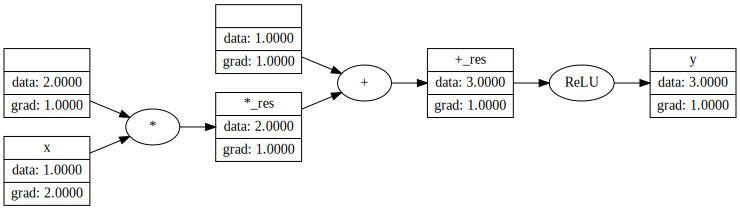

In [4]:
x = Var(1.0, label='x')
y = (x * 2 + 1).relu(); y.label='y'
y.backward()
plot_computational_graph(y)

## Single Neuron

In [5]:
import random
from picograd.nn import Neuron

random.seed(5486)
n = Neuron(2, activation='relu')
print(n)
print(n.parameters())

Neuron(2, relu)
[Var(data=0.07822845723954064), Var(data=0.06208218763697615), Var(data=0.1581407774947987)]


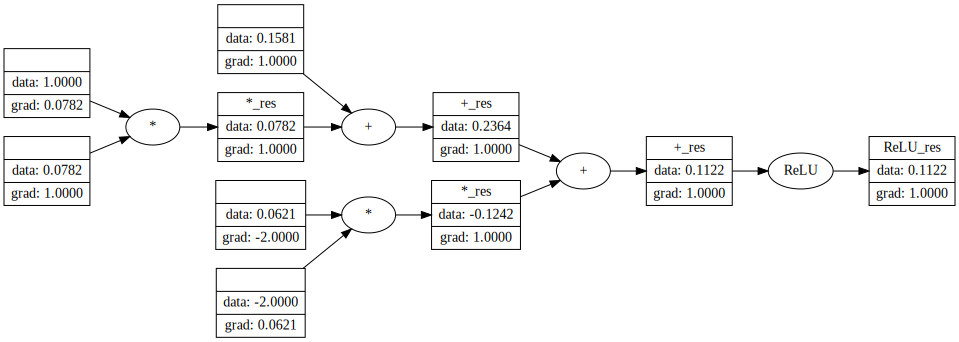

In [6]:
n.zero_grad()
x = [Var(1.0), Var(-2.0)]
y = n(x)
y.backward()
plot_computational_graph(y)

## Multi-Layer Perceptron

### Learning XOR, using an explicit training loop

In [7]:
from picograd.engine import Var

x_train = [list(map(Var, x)) for x in [[0, 0], [0, 1], [1, 0], [1, 1]]]
print(x_train)
y_train = [Var(0), Var(1), Var(1), Var(0)]

[[Var(data=0), Var(data=0)], [Var(data=0), Var(data=1)], [Var(data=1), Var(data=0)], [Var(data=1), Var(data=1)]]


In [8]:
from picograd.nn import MLP
from picograd.optim import SGD, Adam
from picograd.metrics import mean_squared_error

model = MLP(in_features=2, layers=[4, 1], activations=['relu', 'linear']) # 1 hidden layer
print(model)
print(f"Number of parameters: {len(model.parameters())}")

optimizer = SGD(model.parameters(), lr=0.01)
num_epochs = 10000

for epoch in range(num_epochs):
    # Reset the gradients of model parameters
    optimizer.zero_grad()
    
    # Forward pass
    outputs = list(map(model, x_train))
    
    # Loss computation
    y_pred = [item for sublist in outputs for item in sublist]
    loss = mean_squared_error(y_train, y_pred)
    
    # Backprop and gradient descent
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.data}")

MLP of [Layer of [Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu)], Layer of [Neuron(4, linear)]]
Number of parameters: 17
Epoch [0/10000], loss: 1.4299425249394688
Epoch [100/10000], loss: 0.2792828142137011
Epoch [200/10000], loss: 0.2235485288422007
Epoch [300/10000], loss: 0.17934672002547392
Epoch [400/10000], loss: 0.15320426626822
Epoch [500/10000], loss: 0.1341904930563754
Epoch [600/10000], loss: 0.11853619146152647
Epoch [700/10000], loss: 0.10486788583038205
Epoch [800/10000], loss: 0.09311760445132325
Epoch [900/10000], loss: 0.08213031180430044
Epoch [1000/10000], loss: 0.07161372369356092
Epoch [1100/10000], loss: 0.06212125098508617
Epoch [1200/10000], loss: 0.053104030724664304
Epoch [1300/10000], loss: 0.04482746863669852
Epoch [1400/10000], loss: 0.03720344979371739
Epoch [1500/10000], loss: 0.03059736744604425
Epoch [1600/10000], loss: 0.024790459047215798
Epoch [1700/10000], loss: 0.019816903158239706
Epoch [1800/10000], loss: 0.015666073679820564

In [9]:
# Compare predictions and ground truth
for x, y in zip(x_train, y_train):
    y_pred = model(x)
    print(f"Predicted: {y_pred[0].data:.5f}, actual: {y.data}")

Predicted: 0.00000, actual: 0
Predicted: 1.00000, actual: 1
Predicted: 1.00000, actual: 1
Predicted: 0.00000, actual: 0


## Classifying 2D data, using the training API


In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons

In [11]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

x_train: (200, 2). y_train: (200,)


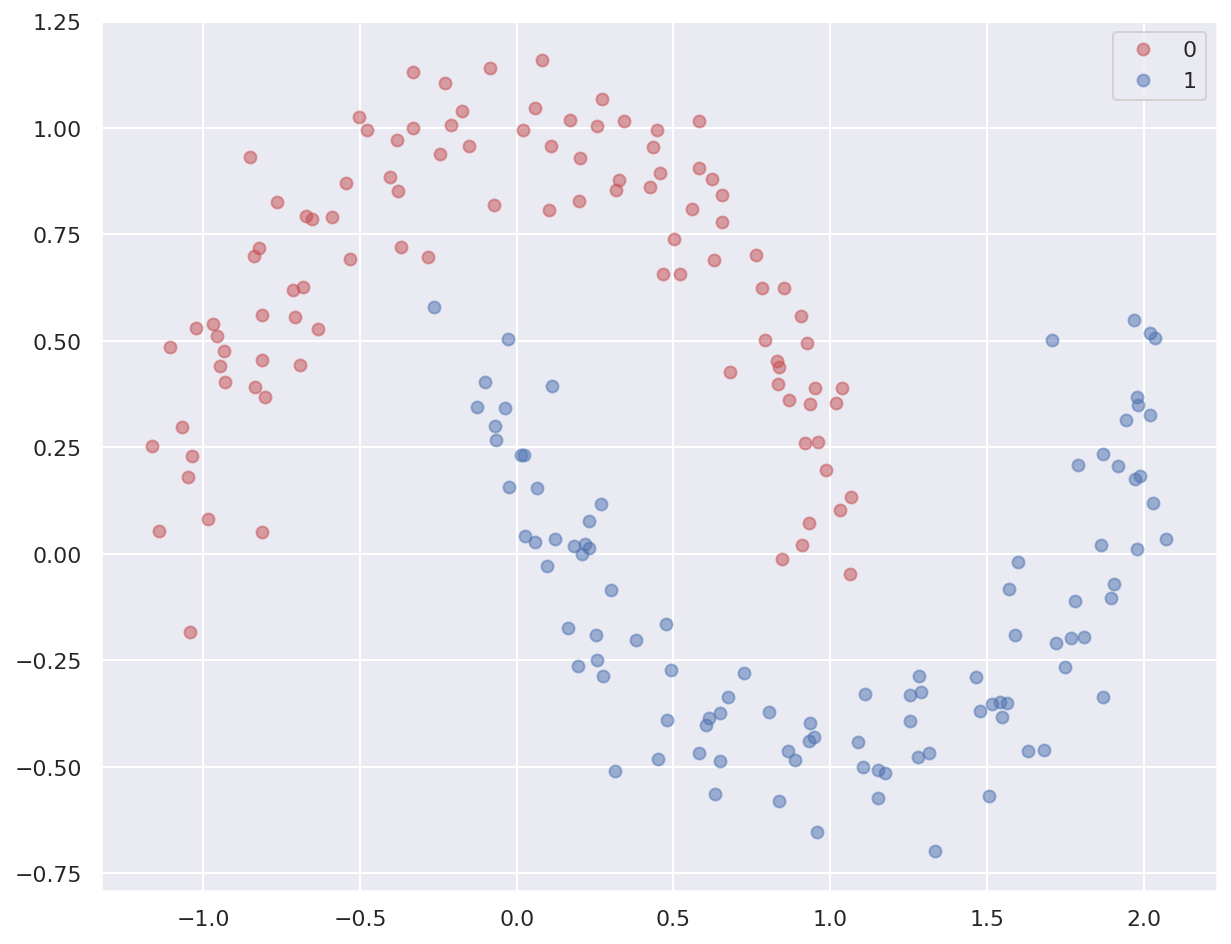

In [12]:
def plot_planar_data(X, y):
    """Plot some planar data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], 'ob', alpha=0.5, label=1)
    plt.legend()

# Generate moon-shaped, non-linearly separable data
x_train, y_train = make_moons(n_samples=200, noise=0.10, random_state=0)

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')
plot_planar_data(x_train, y_train)

In [13]:
from picograd.nn import MLP
from picograd.engine import Var
from picograd.data import BatchIterator
from picograd.trainer import Trainer
from picograd.optim import SGD, Adam
from picograd.metrics import binary_accuracy, mean_squared_error


model = MLP(in_features=2, layers=[16, 16, 1], activations=['relu', 'relu', 'linear']) # 2 hidden layers
print(model)
print(f"Number of parameters: {len(model.parameters())}")

optimizer = SGD(model.parameters(), lr=0.05)
data_iterator = BatchIterator(x_train, list(map(Var, y_train)))
trainer = Trainer(model, optimizer, loss=mean_squared_error, acc_metric=binary_accuracy)

history = trainer.fit(data_iterator, num_epochs=70, verbose=True)

MLP of [Layer of [Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu), Neuron(2, relu)], Layer of [Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu), Neuron(16, relu)], Layer of [Neuron(16, linear)]]
Number of parameters: 337
Epoch [1/70], loss: 11.169831, accuracy: 36.50%
Epoch [2/70], loss: 2.362962, accuracy: 49.50%
Epoch [3/70], loss: 1.046105, accuracy: 80.00%
Epoch [4/70], loss: 0.622207, accuracy: 91.50%
Epoch [5/70], loss: 0.423670, accuracy: 94.50%
Epoch [6/70], loss: 0.368302, accuracy: 96.50%
Epoch [7/70], loss: 0.271892, accuracy: 96.00%
Epoch [8/70], loss: 0.2

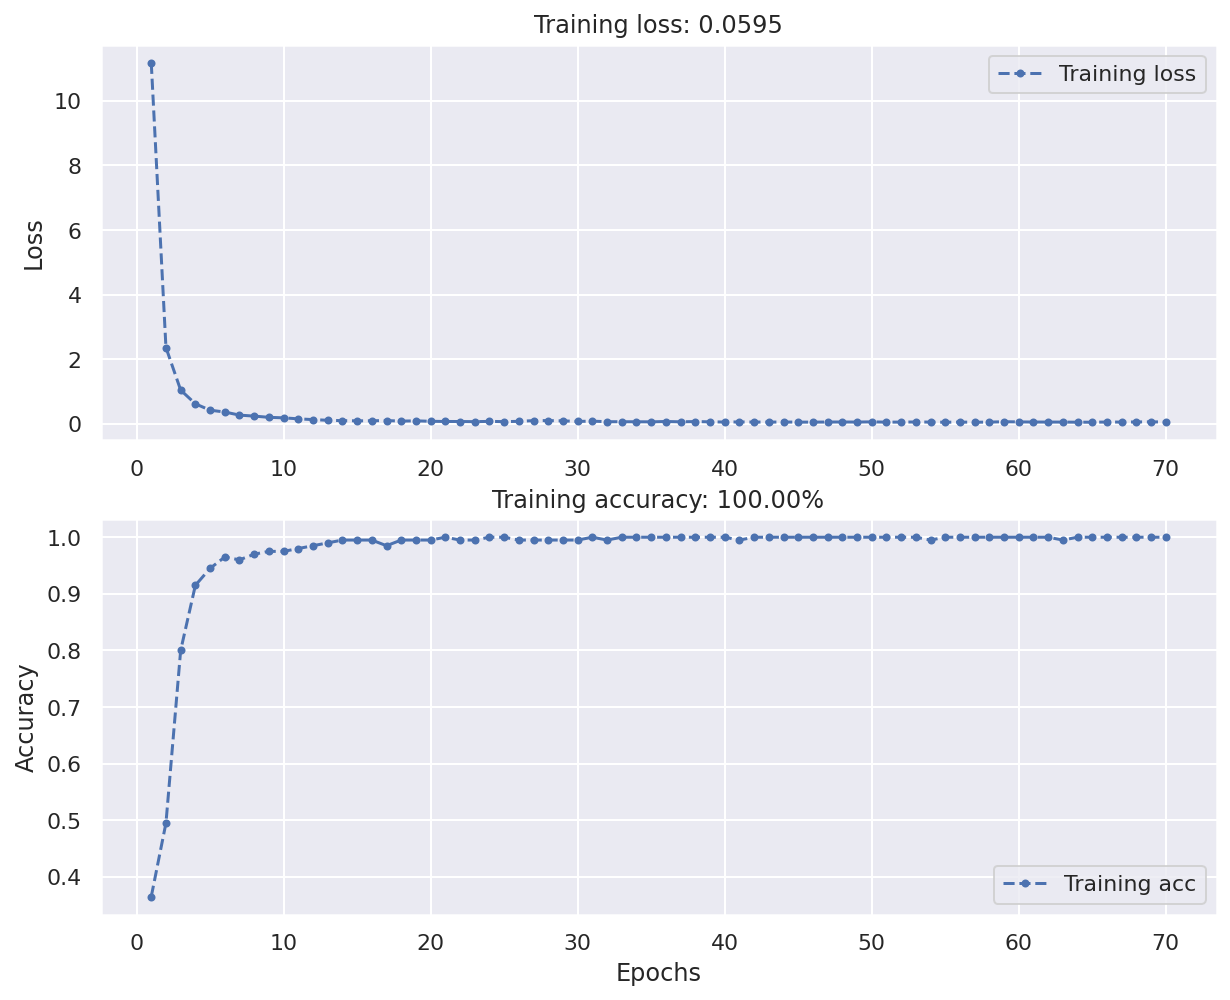

In [14]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

    acc = history['acc']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()

plot_loss_acc(history)

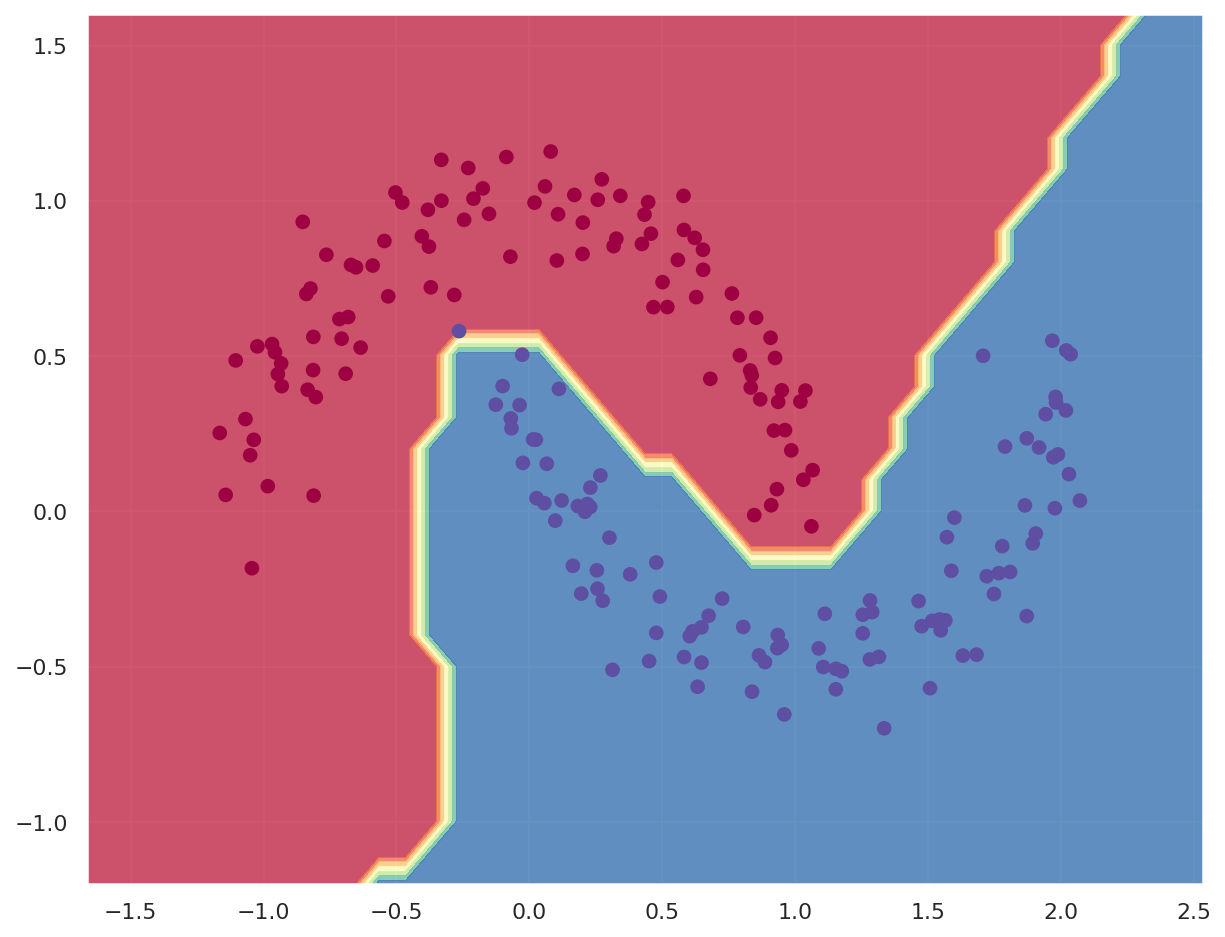

In [15]:
def plot_decision_boundary(model, X, y):
    """Plot a decision boundary"""

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.1
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Var, xrow)) for xrow in Xmesh]
    outputs = list(map(model, inputs))
    y_pred = [item for sublist in outputs for item in sublist]
    Z = np.array([s.data > 0.5 for s in y_pred])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plot_decision_boundary(model, x_train, y_train)

In [16]:
# Compare predictions and ground truth
for x, y in zip(x_train[:30], y_train[:30]):
    y_pred = model(x)
    print(f"Predicted: {y_pred[0].data:.5f}, actual: {y}")

Predicted: -0.03407, actual: 0
Predicted: 1.00691, actual: 1
Predicted: 0.93207, actual: 1
Predicted: -0.24457, actual: 0
Predicted: 0.95621, actual: 1
Predicted: 0.95621, actual: 1
Predicted: -0.02645, actual: 0
Predicted: 0.99226, actual: 1
Predicted: -0.03246, actual: 0
Predicted: 1.06592, actual: 1
Predicted: 0.19223, actual: 0
Predicted: 0.93757, actual: 1
Predicted: 0.95621, actual: 1
Predicted: 0.94970, actual: 1
Predicted: -0.18090, actual: 0
Predicted: -0.01868, actual: 0
Predicted: -0.04211, actual: 0
Predicted: 0.91280, actual: 1
Predicted: 0.01215, actual: 0
Predicted: -0.24846, actual: 0
Predicted: 0.95621, actual: 1
Predicted: 0.97209, actual: 1
Predicted: -0.10186, actual: 0
Predicted: 0.91185, actual: 1
Predicted: -0.12059, actual: 0
Predicted: 0.96167, actual: 1
Predicted: 0.95621, actual: 1
Predicted: 0.95621, actual: 1
Predicted: 1.03282, actual: 1
Predicted: 0.12694, actual: 0
